**Implementation of the original Grad-CAM paper https://arxiv.org/abs/1610.02391**

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target class flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the class. 

This results in a coarse saliency map, which can then be resized to the
original input image size to render a class-discriminative saliency map.

**Goal: To see where our trained model is paying attention to and see if the predictions trained on class labels have anything to do with the real bounding boxes.**

**This notebook uses two network trained in my two seperate notebooks, one trained to classify opacity vs None (Image level classes), the other, for 4 classes of 'Negative for Pneumonia' 'Typical Appearance' 'Indeterminate Appearance' 'Atypical Appearance' (Study level classes)**

[First Notebook](https://www.kaggle.com/sinamhd9/image-label-classification-opacity-vs-none)

[Second Notebook](https://www.kaggle.com/sinamhd9/classification-model)

**Note that the reference notebooks may get updated to achieve better accuracy based on the insights from this notebook**

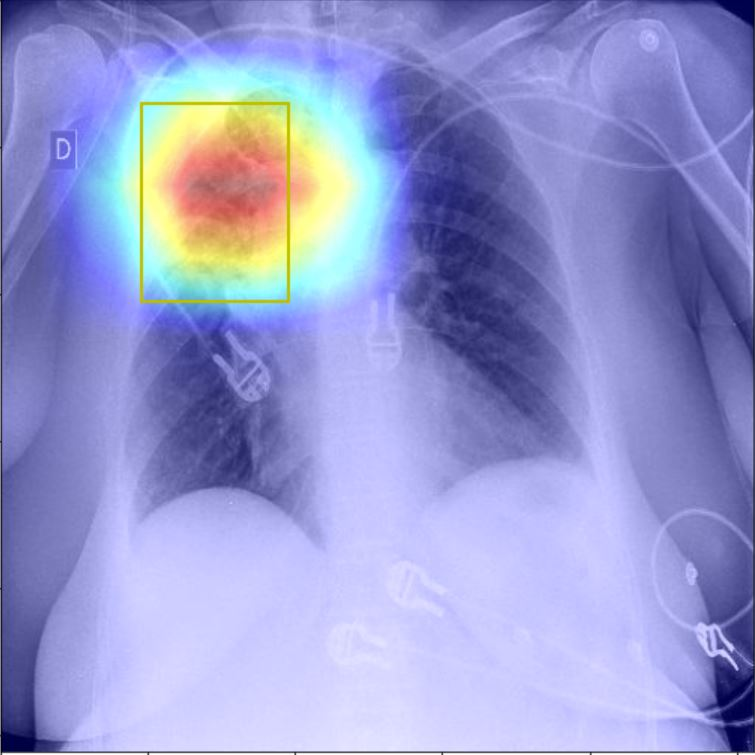

# Imports

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import pandas as pd 
from matplotlib.patches import Rectangle
from ast import literal_eval
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
import os

# Same processing as original notebooks

In [ ]:
df_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
df_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
df_study['id'] = df_study['id'].str.replace('_study',"")
df_study.rename({'id': 'StudyInstanceUID'},axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')
df_train.loc[df_train['Negative for Pneumonia']==1, 'study_label'] = 'negative'
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)
df_train['id'] = df_train['id'].str.replace('_image', '.jpg')
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_size = pd.read_csv('../input/covid-jpg-512/size.csv')
df_train = df_train.merge(df_size, on='id')
df_train.head(3)

In [ ]:
def preprocess_image(img):
    equ_img = exposure.equalize_hist(img)
    return equ_img

img_size = 299
batch_size = 16

image_generator = ImageDataGenerator(
        validation_split=0.2,
        #rotation_range=20,
        horizontal_flip = True,
        zoom_range = 0.1,
        #shear_range = 0.1,
        brightness_range = [0.8, 1.1],
        fill_mode='nearest',
        preprocessing_function=preprocess_image
)

image_generator_valid = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_image)

train_generator1 = image_generator.flow_from_dataframe(
        dataframe = df_train,
        directory='../input/covid-jpg-512/train',
        x_col = 'id',
        y_col =  'image_label',  
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training', seed = 23) 

valid_generator1 = image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='../input/covid-jpg-512/train',
    x_col = 'id',
    y_col = 'image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation', shuffle=False, seed=23) 

train_generator2 = image_generator.flow_from_dataframe(
        dataframe = df_train,
        directory='../input/covid-jpg-512/train',
        x_col = 'id',
        y_col =  'study_label',  
        target_size=(img_size, img_size),
        batch_size=batch_size,
        subset='training', seed = 23) 

valid_generator2 = image_generator_valid.flow_from_dataframe(
    dataframe = df_train,
    directory='../input/covid-jpg-512/train',
    x_col = 'id',
    y_col = 'study_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation', shuffle=False, seed=23) 


In [ ]:
def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img

# Main Grad-CAM algorithm

In [ ]:
def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam)) 
    return L_gradCam.numpy()

# Blend

Superimposing gradCAM heatmap on the original image

In [ ]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

# Loading model of notebook 1 (Opacity vs None)

In [ ]:
trained_model = load_model('../input/image-label-classification-opacity-vs-none/model.h5')

## Results

In [ ]:
def plot_results(model, gen):
    n = 50
    train_dir = '../input/covid-jpg-512/train'
    fig, axs = plt.subplots(10, 5, figsize=(20,60))
    fig.subplots_adjust(hspace=.5, wspace=.1)
    axs = axs.ravel()
    gen.next()
    classes = list(gen.class_indices.keys()) 
    idx = gen.index_array
    layer_name = 'block14_sepconv2_act'
    for i in range(n):
        sample_img_path = os.path.join(train_dir, df_train['id'][idx[i]])
        img = load_process(sample_img_path, img_size)
        pred = model.predict(img)
        grad_cam_img = grad_cam(img, model, layer_name)
        heatmap_img, result_img = blend(sample_img_path, grad_cam_img, 0.5)
        axs[i].imshow(result_img[:,:,::-1]/255)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if type(df_train['boxes'][idx[i]])==str:
            boxes = literal_eval(df_train['boxes'][idx[i]])
            for box in boxes:
                axs[i].add_patch(Rectangle((box['x']*(512/df_train['dim1'][idx[i]]), box['y']*(512/df_train['dim0'][idx[i]])), box['width']*(512/df_train['dim1'][idx[i]]), box['height']*(512/df_train['dim0'][idx[i]]), fill=0, color='y', linewidth=2))
                axs[i].set_title(f"{df_train['study_label'][idx[i]]}, {df_train['image_label'][idx[i]]}")
        else:
            axs[i].set_title(df_train['study_label'][idx[i]])
        
        axs[i].set_xlabel(f"{classes[np.argmax(pred)]}, {round(pred[0][np.argmax(pred)]*100, 2)}%")

### Training images

In [ ]:
plot_results(trained_model, train_generator1)

### Validation images

In [ ]:
plot_results(trained_model, valid_generator1)

# Loading model of notebook 2 ('Negative' 'Typical' 'Indeterminate' 'Atypical')

In [ ]:
trained_model2 = load_model('../input/classification-model/model.h5')

## Results

### Training images

In [ ]:
plot_results(trained_model2, train_generator2)

### Validation images

In [ ]:
plot_results(trained_model2, valid_generator2)